In [2]:
from util import create_dir, replace_dir, Clock, compare_dir, split_parameters
from transform_img import flatten_onehot, Diff_size_collect, get_transform, norm_black_color,get_pretreat_transform
from loss import Soft_dice_loss, Focal_loss, SSIM, activate
from plot import plot_grad_flow, Progress_writer, onehot_gird, Loss_record, IOU_record, Loss_writer
from dataset.dataset import Image_Dataset, Zip_dataset, get_data_files
from dataset.tarpath import Tar_path
from dataset.lmdb_format import Lmdb_dataset

from torch.utils.data import DataLoader, Subset
from torchsummary import summary

from net.unet import U_Net
from net.nested_unet import NestedUNet
from net.regseg import RegSeg
from net.regseg_p import RegSeg_dp

import tarfile
from pathlib import Path
from itertools import islice
import copy
from datetime import datetime, timedelta
import cv2
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch
import numpy as np
import matplotlib
from torch.cuda.amp import GradScaler

In [ ]:
DATA_DIR = "../data/graduate/lip_c1_db"

TRAIN_IMG_DIR = "./training"
TRAIN_GD_TRUTH_DIR = "./training_seg"

VAL_IMG_DIR = "./validation"
VAL_GD_TRUTH_DIR = "./validation_seg"

TEST_IMG_DIR = "./test"
OUTPUT_CHANNEL = 1

transform, target_transform, transform_rm_rand_layer, target_transform_rm_rand_layer = get_pretreat_transform(
    OUTPUT_CHANNEL)


# 创建训练数据集
train_img_dataset = Lmdb_dataset(DATA_DIR, TRAIN_IMG_DIR, transform)

train_target_img_dataset = Lmdb_dataset(
    DATA_DIR, TRAIN_GD_TRUTH_DIR, target_transform)

train_dataset = Zip_dataset(train_img_dataset, train_target_img_dataset)
# 验证数据集
val_img_dataset = Lmdb_dataset(
    DATA_DIR, VAL_IMG_DIR, transform_rm_rand_layer)

val_target_img_dataset = Lmdb_dataset(
    DATA_DIR, VAL_GD_TRUTH_DIR, target_transform_rm_rand_layer)

val_dataset = Zip_dataset(val_img_dataset, val_target_img_dataset)



In [ ]:
for x, y in islice(val_dataset, 4):
    print(torch.bincount(y.int().flatten()))

    plt.figure()
    plt.subplot(311)
    plt.imshow(x.permute((1, 2, 0)))
    plt.subplot(312)
    plt.imshow(y.permute((1, 2, 0)))
    plt.subplot(313)
    x[:,y[0]<0.5] = 0
    plt.imshow(x.permute((1, 2, 0)))
    plt.show()

In [ ]:
class Binary_loss(torch.nn.Module):
    def __init__(self,
                 focal: torch.nn.Module,
                 ssim: torch.nn.Module,
                 dice: torch.nn.Module) -> None:
        super().__init__()
        self.focal_loss = focal
        self.ssim_loss = ssim
        self.dice_loss = dice

    def forward(self, input: torch.Tensor, target: torch.Tensor):
        loss = self.focal_loss(input, target)
        input = torch.sigmoid(input)
        loss += self.ssim_loss(input, target) + self.dice_loss(input, target)
        return loss

    @staticmethod
    def mk_loss_record(focal_loss, ssim_loss, dice_loss, step: int, tag: str, prefix: str = ""):
        focal_record = Loss_record(
            focal_loss, step, tag, prefix)
        ssim_record = Loss_record(
            ssim_loss, step, tag, prefix)
        dice_record = Loss_record(
            dice_loss, step, tag, prefix)

        unet_loss = Binary_loss(focal_record, ssim_record, dice_record)
        unet_loss_record = Loss_record(
            unet_loss, step, tag, prefix)
        return focal_record, ssim_record, dice_record, unet_loss_record


focal_loss = Focal_loss(alpha=0.5, mul_class=False)
ssim_loss = SSIM(activated=True)
dice_loss = Soft_dice_loss(activated=True)

test_size = 100

train_loss = Binary_loss.mk_loss_record(
    focal_loss, ssim_loss, dice_loss, test_size, "Training", "tr")
valid_loss = Binary_loss.mk_loss_record(
    focal_loss, ssim_loss, dice_loss, test_size, "Validation", "vl")

rs = train_loss + valid_loss

train_loss = train_loss[-1]
valid_loss = valid_loss[-1]

for x, y in islice(val_dataset, 1):
    y = y.unsqueeze(0)
    fy = y*12-6
    w = torch.zeros((1, 1, 1, 3), dtype=torch.float32)
    w[..., 0] = 1

    for i in range(100):
        loss = valid_loss(fy, y)
        train_loss(fy, y)
        fy = F.conv2d(fy, w, padding=(0, 1))

for r in rs:
    plt.figure()
    plt.plot(range(test_size), r.log)
    plt.show()


0.000543020715963567


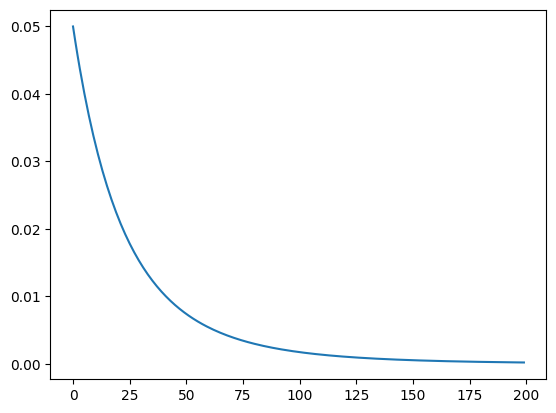

In [40]:
a = [0.05]
Max = 200

for i in range(1,Max):
    a.append(
        a[0]*((1+1.5*i/float(Max))**-6)
    )
plt.plot(range(Max), a)
print(a[150])


In [ ]:
LABEL_C5 = {
    1: "Hair",
    2: "Face",
    3: "body",
    4: "Leg",
    5: "Arm"
}
LABEL_C12 = {
    1: "Hat",
    2: "Hair",
    3: "Arm",
    4: "Sunglasses",
    5: "Clothes",
    6: "Dress",
    7: "Leg",
    8: "Pants",
    9: "Torso-skin",
    10: "Scarf",
    11: "Skirt",
    12: "Face",
}

